# Data Science Workflow

## Connect to SAS Viya

Note: We use swat - SAS Scripting Wrapper for Analytics Transfer - available via *pip install swat*

In [1]:
import yaml
import getpass
import os

# Load the yaml file
os.chdir("/home/jovyan/work/development")
stream = open('viya_config.yml', 'r')
settings = yaml.load(stream, yaml.SafeLoader)

# connection parameters
hostname = settings['hostname']
port = settings['port']
username = settings['username']
password = getpass.getpass()

 ········


In [2]:
import swat

# Connect to CAS server
s = swat.CAS(hostname, port, username, password)
# Define default caslib
s.sessionprop.setsessopt(caslib='Public')

NOTE: 'Public' is now the active caslib.


+ Elapsed: 0.000519s, user: 0.00046s, mem: 0.261mb

## Access Data - CAS

In [3]:
table_name = 'hmeq_id'

# load table in memory
s.table.loadTable(path=str(table_name).upper()+".sashdat", casout={"name":table_name, "replace":True})

# CASTable view
castbl = s.CASTable(table_name)

NOTE: Cloud Analytic Services made the file HMEQ_ID.sashdat available as table HMEQ_ID in caslib Public.


# Local data analysis

In [4]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# Bring data locally
df = castbl.to_frame()

## Data Exploration and Preparation - Local

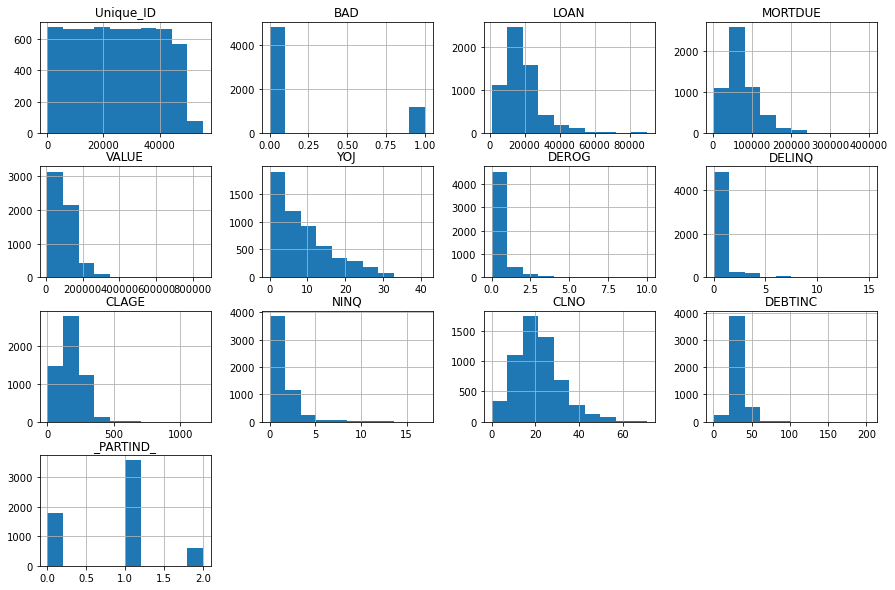

In [6]:
hists = df.hist(figsize = (15, 10))

### set variable shortcuts

In [7]:
# Define target variable
target = 'BAD'

# get categorical/numerical variables
input_vars = df.drop(target,axis=1).columns.values
kinds = np.array([dt.kind for dt in df.drop(target,axis=1).dtypes])

# Variable lists
categorical_vars = list(input_vars[kinds == 'O'])
numerical_vars = [i for i in list(input_vars[kinds != 'O']) if i not in ['Unique_ID','_PARTIND_']]
all_vars = categorical_vars + numerical_vars + [target]

### Prepare data for model

In [8]:
# Split into training and validation / target and inputs
X_train = df[df['_PARTIND_'] == 1].drop([target,'Unique_ID','_PARTIND_'], axis = 1)
X_valid = df[df['_PARTIND_'] == 0].drop([target,'Unique_ID','_PARTIND_'], axis = 1)
y_train = df[df['_PARTIND_'] == 1][target]
y_valid = df[df['_PARTIND_'] == 0][target]

## Build model - Scikit-learn

In [9]:
# Define data pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_vars),
    ('cat', categorical_transformer, categorical_vars)])

ml_pipe = Pipeline(steps=[
('preprocessor', preprocessor),
('model', GradientBoostingClassifier(random_state=3))])

fit = ml_pipe.fit(X_train, y_train)

### Assess model

In [10]:
# put results in pandas dataframe
results_df = pd.DataFrame(dict(actual = y_valid, pred = ml_pipe.predict_proba(X_valid)[:,1]))

# Predict and assess model
gb_y_score           = ml_pipe.predict(X_valid)
gb_misclassification = 1 - accuracy_score(y_valid, gb_y_score)
gb_confusion_matrix  = confusion_matrix(y_valid, gb_y_score)

# Add Python model results to CAS to assess
pytbl = s.upload_frame(results_df, casout=dict(name='GBT_sklearn_predictions', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GBT_SKLEARN_PREDICTIONS in caslib Public.
NOTE: The table GBT_SKLEARN_PREDICTIONS has been created in caslib Public from binary data uploaded to Cloud Analytic Services.


In [11]:
gb_misclassification

0.10067114093959728

# Data Analysis on CAS

In [12]:
# Load actionsets for analysis (for data prep, modeling, assessing)
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'regression', 'neuralNet', 'svm', 'astore','autotune']
actions = [s.loadactionset(i) for i in actionsets]

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'autotune'.


In [13]:
s.dataStep.runCode(                   
   code='''data "HMEQ_ID";
   length "BAD_CONVERTED"n varchar(16);
   set "HMEQ_ID";
   format "BAD_CONVERTED"n $CHAR16.;
   "BAD_CONVERTED"n= PUT("BAD"n,BEST16.);
   run;''')
castbl.table.altertable(columns=[{'name':'BAD','drop':True},{'name':'BAD_CONVERTED','rename':'BAD','label':'Default on Loan'}])

+ Elapsed: 0.000844s, user: 0.000779s, mem: 0.301mb

## Data Exploration and Preparation - CAS

/tmp/ipykernel_57/2700989529.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

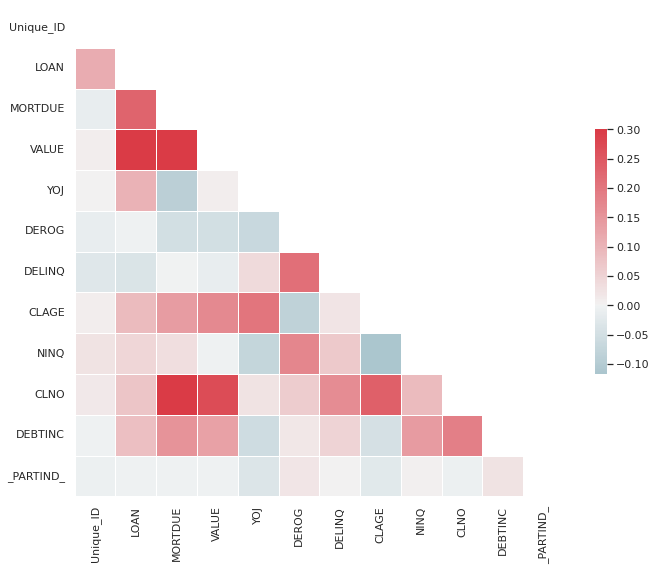

In [14]:
# Compute correlation matrix
corr = castbl.corr()

# Visualize with Seaborn
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Build models - CAS

In [15]:
import collections

# Models to be performed
models = collections.OrderedDict()
models['dt']  = 'Decision Tree'
models['gbt'] = 'Gradient Boosting'
models['nn']  = 'Neural Network'
# models['svm'] = 'Support Vector Machine'

# Impute missing values
castbl.dataPreprocess.impute(
    outVarsNamePrefix = 'IMP',
    methodContinuous  = 'MEDIAN',
    methodNominal     = 'MODE',
    inputs            = categorical_vars + numerical_vars,
    copyAllVars       = True,
    casOut            = dict(name = 'hmeq_imputed', replace = True)
)
castbl_imp = s.CASTable('hmeq_imputed')

# Set key-word argument shortcuts (common model inputs)
## For models that can handle missing values (decision tree, gradient boosting)
params = dict(
    table    = dict(name = table_name, where = '_PARTIND_ = 1'), 
    target   = target, 
    inputs   = categorical_vars + numerical_vars, 
    nominals = categorical_vars,
)

## For models that can't have missing values (neural network, support vector machine)
casinfo = castbl_imp.columninfo()['ColumnInfo']
imp_params = dict(
    table    = dict(name = 'hmeq_imputed', where = '_PARTIND_ = 1'), 
    target   = target, 
    inputs   = [x for x in list(casinfo['Column']) if x != target and ('IMP_' in x)], 
    nominals = [x for x in list(casinfo[casinfo.Type == 'varchar']['Column']) if x != target and ('IMP' in x)],
)

### Decision Tree - CAS

In [16]:
dt = s.decisionTree.dtreeTrain(**params, varImp = True, casOut = dict(name = 'dt_model', replace = True))

### Gradient Boosting - CAS

In [17]:
gbt = s.decisionTree.gbtreeTrain(**params, seed = 1, casOut = dict(name = 'gbt_model', replace = True), saveState=dict(name = 'gradboost_model', replace = True))

NOTE: 975891 bytes were written to the table "gradboost_model" in the caslib "Public".


### Neural Network - CAS

In [18]:
nn = s.neuralNet.annTrain(**imp_params, seed = 1, hiddens={5,5}, acts={"TANH"}, targetAct="SOFTMAX", nloOpts={"lbfgsOpt":{"numCorrections":6},"optmlOpt":{"maxIters":250,"fConv":1e-10},"validate":{"frequency":1}}, casOut = dict(name = 'nn_model', replace = True))

# Model Comparison

## Score the Models on Validation Data - CAS/Python

In [19]:
def score_model(model):
    score = dict(
        table      = 'hmeq_imputed',
        modelTable = model + '_model',
        copyVars   = [target, '_PARTIND_', 'Unique_ID'],
        casOut     = dict(name = '_scored_' + model, replace = True)
    )
    return score

### Decision Tree
s.decisionTree.dtreeScore(**score_model('dt'))
### Gradient Boosting
s.decisionTree.gbtreeScore(**score_model('gbt'))
### Neural Network
s.neuralNet.annScore(**score_model('nn'))

### Create standardized prediction column
for i in range(len(models)):
    s.dataStep.runCode('''
        data _scored_''' + list(models)[i] + '''; 
            set _scored_''' + list(models)[i] + ''';
            if _''' + list(models)[i] + '''_predname_ = 1
                then p_''' + target + '''1 = _''' + list(models)[i] + '''_predp_; 
                else p_''' + target + '''1 = 1 - _''' + list(models)[i] + '''_predp_;
        run;
    ''')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:69
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:69  (occurred 12 times)
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:71
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:71  (occurred 12 times)
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:69
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:69  (occurred 12 times)


## Assess the Performance - CAS/Python

In [20]:
# Model assessment function
def assess_model(model):
    assess = s.percentile.assess(
        table    = dict(name = '_scored_' + model, where = '_PARTIND_ = 0'),
        inputs   = 'p_' + target + '1',      
        response = target,
        event    = '1',
    )
    return assess

# Loop through the models and append to the roc_df dataframe
roc_df  = pd.DataFrame()
for i in range(len(models)):
    tmp = assess_model(list(models)[i])
    tmp.ROCInfo['Model'] = list(models.values())[i]
    roc_df = pd.concat([roc_df, tmp.ROCInfo])

## Compare Misclassification & ROC Curves - CAS/Python

In [21]:
# Assess the Python model using CAS
python_assess = pytbl.percentile.assess(
    inputs   = 'pred',      
    response = 'actual',
    event    = '1',   
)
python_assess.ROCInfo['Model'] = 'Gradient Boosting - sklearn'
roc_df['Model'] = roc_df['Model'] + ' - CAS'
roc_df = pd.concat([roc_df, python_assess.ROCInfo])
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'Misclassification']].reset_index(drop = True)
miss.sort_values('Misclassification')


   Misclassification Rate Comparison  


,Model,Misclassification
1,Gradient Boosting - CAS,0.098434
3,Gradient Boosting - sklearn,0.100671
0,Decision Tree - CAS,0.123602
2,Neural Network - CAS,0.135347


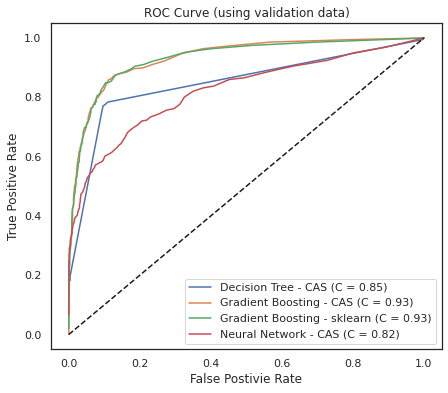

In [22]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)');

# Register Model

In [23]:
# SAS Model Manager Project Name
PROJECT_NAME = "ModelOps SCH"

## Add model to repository - CAS

In [145]:
from sasctl import Session
from sasctl.tasks import register_model

astore = s.CASTable('gradboost_model')
with Session("https://"+hostname, username, password, verify_ssl=False):
    register_model(astore, 'SAS Viya GBT (swat)', PROJECT_NAME, version='latest')

/opt/conda/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.96.1.158'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


NOTE: Added action set 'astore'.
NOTE: Cloud Analytic Services saved the file _39C64348EC0B4548BC303EC13.sashdat in caslib ModelStore.


/opt/conda/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.96.1.158'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## Add model to repository - sklearn

In [24]:
import sasctl.pzmm as pzmm
from utils.mm_utils import *

# model
MODEL = ml_pipe
MODEL_PREFIX = 'Sklearn_GBT'

### Initialize folder & save pickle

In [25]:
# create model folder
MODEL_FOLDER = init_folder(MODEL_PREFIX)
pzmm.PickleModel.pickleTrainedModel(None, MODEL, MODEL_PREFIX, MODEL_FOLDER)

Model Sklearn_GBT was successfully pickled and saved to /home/jovyan/work/development/models/Sklearn_GBT/Sklearn_GBT.pickle.


### Write requirement.txt

In [26]:
# write_requirements(MODEL_FOLDER, 'requirements.txt')

In [27]:
%%writefile $MODEL_FOLDER/requirements.txt
scikit-learn==1.0.2
pandas==1.4.0

Overwriting /home/jovyan/work/development/models/Sklearn_GBT/requirements.txt


### Write inference script

In [28]:
# threshold for prediction
threshold = 0.5
# Get list of variables
vars_string = str(input_vars).replace(" ", ", ")
print(vars_string)
remove_characters = ["'", "[", "]"]
for character in remove_characters:
    vars_string = vars_string.replace(character, "")

['Unique_ID', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG'
, 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', '_PARTIND_']


In [29]:
scoringstring = '''
import pickle
import pandas as pd
                            
global _thisModelFit
        
with open('{0}', 'rb') as _pFile:
    _thisModelFit = pickle.load(_pFile)

def scoreSklearn_GBT({1}):
    "Output: EM_EVENTPROBABILITY, EM_CLASSIFICATION"
    
    try:
        _thisModelFit
    except NameError:

        with open('{0}', 'rb') as _pFile:
            _thisModelFit = pickle.load(_pFile)
    
    inputArray = pd.DataFrame([[{1}]], columns = {2})
    
    prediction = _thisModelFit.predict_proba(inputArray)

    EM_EVENTPROBABILITY = float(prediction[:,1])

    if (EM_EVENTPROBABILITY >= {3}):
        EM_CLASSIFICATION = '1'
    else:
        EM_CLASSIFICATION = '0'

    return(EM_EVENTPROBABILITY, EM_CLASSIFICATION)
'''.format(MODEL_PREFIX + '.pickle',vars_string, str(input_vars).replace(" ", ", "),str(threshold))

In [30]:
text_file = open(MODEL_FOLDER + '/' + MODEL_PREFIX + 'Score.py', "w")
n = text_file.write(scoringstring)
text_file.close()

### Write Metadata files

In [31]:
# init JSONFiles object for metadata files
JSONFiles = pzmm.JSONFiles()

#### input variables

In [32]:
#write input.json
JSONFiles.writeVarJSON(df[input_vars], isInput=True, jPath=MODEL_FOLDER)

/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

inputVar.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/inputVar.json


/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)


#### output variables

In [33]:
NAMES=['P_BAD0', 'P_BAD1', 'EM_CLASSIFICATION', 'EM_EVENTPROBABILITY']
LABELS=['0', '1']
EVENTPROB = 0.5

outputVar = get_output_variables(NAMES, LABELS, EVENTPROB)
#write output.json
JSONFiles.writeVarJSON(outputVar, isInput=False, jPath=MODEL_FOLDER)

outputVar.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/outputVar.json


/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

#### model properties

In [34]:
TARGET_VALUE = "1"

In [35]:
JSONFiles.writeModelPropertiesJSON(modelName=MODEL_PREFIX,
                                   modelDesc='Sklearn classifier',
                                   targetVariable=target,
                                   modelType='Pipeline Gradient Boosting',
                                   modelPredictors=input_vars,
                                   targetEvent=TARGET_VALUE,
                                   numTargetCategories=2,
                                   eventProbVar='EM_EVENTPROBABILITY',
                                   jPath=MODEL_FOLDER,
                                   modeler=username)

ModelProperties.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/ModelProperties.json


In [36]:
# fileMetatdata file
JSONFiles.writeFileMetadataJSON(MODEL_PREFIX, jPath=MODEL_FOLDER)

fileMetaData.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/fileMetaData.json


#### evaluation data

In [37]:
# Evaluate model (train, validation)
train_fit_df = pd.DataFrame(dict(actual = y_train, pred = ml_pipe.predict_proba(X_train)[:,1]))
results_df = pd.DataFrame(dict(actual = y_valid, pred = ml_pipe.predict_proba(X_valid)[:,1]))

# fit statistics
JSONFiles.calculateFitStat(
    validateData=[np.array(y_valid.astype(int)), np.array(results_df['pred'])],
    trainData=[np.array(y_train.astype(int)), np.array(train_fit_df["pred"])],
    testData=None,
    jPath=MODEL_FOLDER)

# ROCLiftStat
JSONFiles.generateROCLiftStat(
    targetName=target,
    targetValue=TARGET_VALUE,
    swatConn=s,
    validateData=pd.DataFrame({'col1': y_valid.astype(int),'col2': results_df['pred']}),
    trainData=pd.DataFrame({'col1': y_train.astype(int), 'col2': train_fit_df["pred"]}),
    testData=None,
    jPath=MODEL_FOLDER)

dmcas_fitstat.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/dmcas_fitstat.json
NOTE: Added action set 'percentile'.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib Public.
NOTE: The table SCOREDVALUES has been created in caslib Public from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib Public.
NOTE: The table SCOREDVALUES has been created in caslib Public from binary data uploaded to Cloud Analytic Services.
dmcas_roc.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/dmcas_roc.json
dmcas_lift.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/dmcas_lift.json


#### compress model folder

In [38]:
#Zip folder
pzmm.ZipModel.zipFiles(MODEL_FOLDER,MODEL_PREFIX)

### Import Model

In [59]:
zPath = MODEL_FOLDER + "/" + MODEL_PREFIX + '.zip'

with Session("https://"+hostname, username, password, verify_ssl=False):
    zipfile = open(zPath, 'rb')
    model_repository.import_model_from_zip(MODEL_PREFIX,
                                           PROJECT_NAME,
                                           file=zipfile,
                                           version='latest')
    zipfile.close()

/opt/conda/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.96.1.158'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [107]:
#!mkdir -p /opt/sas/viya/config/data/modelsvr/resources/38801ef9-cca2-43c6-940a-498379aada53
joblib.dump(ml_pipe, '/opt/sas/viya/config/data/modelsvr/resources/38801ef9-cca2-43c6-940a-498379aada53/ml_pipe.pickle')

['/opt/sas/viya/config/data/modelsvr/resources/38801ef9-cca2-43c6-940a-498379aada53/ml_pipe.pickle']